Load LiDAR data in las format with laspy library:

In [3]:
import laspy

inFile = laspy.read("c:\\VASP\\openslava\\code\\2510_1138.las")
print("number of points: ", len(inFile.points.array))

number of points:  4964728


Las file contains quite a lot of points so we will select just some portion of them. 
For now we use some kind of grid with 1500 vertical and horizontal lines 

In [4]:
parts = 1500

scaleX = inFile.header.scale[0]
scaleY = inFile.header.scale[1]

height = (inFile.header.maxs[1]/scaleY) - (inFile.header.mins[1]/scaleY)
cut_height = int(height / parts)
print("grid horizontal spacing:", cut_height)

width = (inFile.header.maxs[0]/scaleX) - (inFile.header.mins[0]/scaleX)
cut_width = int(width / parts)
print("grid vertical spacing:", cut_width)

grid horizontal spacing: 48
grid vertical spacing: 66


Here we actually finding points in las file which are on intersection of vertical and horizontal lines of grid. To work with arrays we are using numpy library. And to be more effective we are using numpa library, which is convenverting python in some more effective langugage.

In [5]:
import numpy as np

def getGrid(arrayX, arrayY, arrayPoints, modX, modY):
    index = (arrayX % modX == 0) & (arrayY % modY == 0)
    return arrayPoints[index]

def getFirstMember(x):
    return (x[0], x[1])

print("example of point: ", inFile.points.array[0])    

fullGrid_ = getGrid(inFile.X, inFile.Y, inFile.points.array, cut_width, cut_height)


fullGrid = np.array(list(map(getFirstMember, fullGrid_)))
print("fullGrid:", fullGrid)
print("points in grid: ", len(fullGrid))

example of point:  (0, 87453, 37931, 72, 73, 2, -27, 0, 8019, 2.34738552e+08)
fullGrid: [[ 1782 77280]
 [ 3828 79488]
 [  726 88752]
 ...
 [95040 99408]
 [91014 99216]
 [88110 99600]]
points in grid:  1580


To find polygon which describes borders of these points used alpha shapes algoritm, there is also library in python, but this one needs to have all points coordinates between 0 and 1, so that we need to normalize points from our grid.

In [9]:
import math

scaleNorm = 10**(-1*math.ceil((math.log(fullGrid[0][0],10))+1))
print(scaleNorm)

def normalize(xy):
    x = xy[0] * scaleNorm
    y = xy[1] * scaleNorm
    return (x,y)

gridN = np.array(list(map(normalize, fullGrid)))
print(gridN)

1e-05
[[0.01782 0.7728 ]
 [0.03828 0.79488]
 [0.00726 0.88752]
 ...
 [0.9504  0.99408]
 [0.91014 0.99216]
 [0.8811  0.996  ]]


Here we actually finding polygon, which cand end up as list of polygon when alpha paramether is quite big and points are scattered.

In [17]:
from alpha_shapes.alpha_shapes import Alpha_Shaper

shaper = Alpha_Shaper(gridN)
alpha_shape = shaper.get_shape(15)

from shapely.geometry import Polygon, MultiPolygon
#print(type(alpha_shape))

if(type(alpha_shape) == Polygon):
    print('Polygon')
    print(len(list(alpha_shape.exterior.coords)))
elif(type(alpha_shape) == MultiPolygon):
    print(len(alpha_shape))
    print('MultiPolygon')
    for poly in alpha_shape:
        print(len(list(poly.exterior.coords)))

Polygon
91


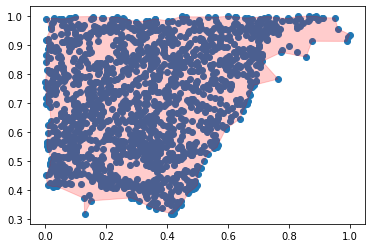

In [18]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch

fig, ax1 = plt.subplots()
ax1.scatter(*zip(*gridN))
ax1.add_patch(PolygonPatch(alpha_shape, alpha=0.2, color='r'))


plt.show()

Now we have polygon and we need to get its coordinates, them denormalize them, apply scale and offset and convert them to latitude, longitude format so we can put them on map.

In [16]:
coords = np.array(list(alpha_shape.exterior.coords))

from pyproj import CRS, Transformer
latLongCRS = CRS.from_epsg(4326)
nad83CAzone6CRS = CRS.from_epsg(2056)
transformer = Transformer.from_crs(2056, 4326)

x_scale = inFile.header.scales[0]
y_scale = inFile.header.scales[1]

x_offset = inFile.header.offsets[0]
y_offset = inFile.header.offsets[1]

def convertCoords(xy,denorm = True):
    x = ((xy[0] / scaleNorm) * x_scale) + x_offset
    y = ((xy[1] / scaleNorm) * y_scale) + y_offset
    return transformer.transform(x,y)

polygonLatLong = list(map(convertCoords, coords))

for coord in polygonLatLong:
    print(coord[1],",",coord[0])

6.274044410901168 , 46.39025332271666
6.2740022566879885 , 46.39021834199876
6.273924857762611 , 46.39022618246773
6.273295601105206 , 46.39035789482295
6.272984797036438 , 46.390445380990364
6.272569646998994 , 46.390596567293564
6.272215664985941 , 46.39069656176785
6.27025293464626 , 46.390188344306594
6.270216959382483 , 46.39066299528993
6.268887916420564 , 46.39101201460807
6.268646668603708 , 46.39105702382207
6.268571509453097 , 46.39135853403531
6.268726224935474 , 46.39174446932105
6.268622437494826 , 46.392179553678695
6.268594834783483 , 46.39226563611718
6.268591759147854 , 46.392408111058664
6.268637738098196 , 46.39266337100453
6.268606593537627 , 46.392913515500204
6.268549527886223 , 46.39356932034565
6.268545053949415 , 46.39377655662029
6.268503650665872 , 46.39410432601263
6.268483135262898 , 46.39425957585822
6.268543572089489 , 46.394640218444145
6.268495265972666 , 46.39489018555361
6.268508138200044 , 46.3950889643365
6.26855514433304 , 46.39529673266507
6.26848